In [1]:
%matplotlib notebook

# Dependencies
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import sys
import pandas as pd

import colony_iomethods as cm
import tracker as tr

from matplotlib import pyplot as plt

In [2]:
# Folder for the files
exp_name = "EQ59_Single_Colony_TilesScan.lif"

folder = f"D:/Tolga/Colony Images/{exp_name}/"
video_folder = f"{folder}/Videos_unmarked/"

movie_csv_path = folder + f"{exp_name}_Boxfiltered_Movie.csv"
combined_csv_path = folder + f"{exp_name}_combined.csv"

In [3]:
# Collect the data info from the combined csv
combined_df = pd.read_csv(combined_csv_path, index_col="Tp_id")
combined_df.dropna(inplace=True)
# combined_df = combined_df[combined_df["comment"] == "Large TileScan"]
combined_df

,tix,plate_id,time,comment,max_filtered_counts,average_counts,acq_name,acq_type,base_folder
Tp_id,,,,,,,,,
1,0,2,13.866667,TileScan init_12h,8,0.056830,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
2,1,2,14.366667,TileScan init_12h,7,0.057373,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
3,2,2,14.866667,TileScan init_12h,9,0.059159,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
4,3,2,15.366667,TileScan init_12h,8,0.060877,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
5,4,2,15.866667,TileScan init_12h,10,0.064520,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
6,5,2,16.366667,TileScan init_12h,10,0.071765,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
7,6,2,16.866667,TileScan init_12h,10,0.081134,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
8,7,2,17.366667,TileScan init_12h,12,0.094280,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
9,8,2,17.866667,TileScan init_12h,0,0.000000,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...


## Choose a timepoint

In [9]:
tpix = 7
tp = combined_df.loc[tpix]

base_folder = tp["base_folder"]
acq_name = tp["acq_name"]


acq_folder = f"D:/Tolga/Colony Images/{exp_name}/{acq_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

## Important!! 
### Each frame is scaled from a tilescan of 1024x1024 images, to a final 512x512 in the video.
* Collect the tilescan positions and obtain the scalex and scaley

* Scale xvoxel and yvoxel accordingly


In [10]:
# Collect information from the xml
dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
xvoxel = dim_desc["xvoxel"]
yvoxel = dim_desc["yvoxel"]
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# Tilescan info
tilescan_desc = cm.collectTileScan(image_xml)
xixar = tilescan_desc["xix_unique_ar"]
yixar = tilescan_desc["yix_unique_ar"]

tile_xcnt = tilescan_desc["tile_xcnt"]
tile_ycnt = tilescan_desc["tile_ycnt"]

scalex = 1.0/tile_xcnt/2
scaley = 1.0/tile_ycnt/2

# Frame info from the video file
t_str = f"Tp{tpix}"
video_path = video_folder + f"{exp_name}_{t_str}.avi"
vidcap = cv2.VideoCapture(video_path)

# Frame properties
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

tilescan is set


## Collect image sequence from 512x512 videos

In [11]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_path):
    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count), dtype=np.uint8)
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq

## Interactive plot for checking  threshold, and finding the center

<IPython.core.display.Javascript object>


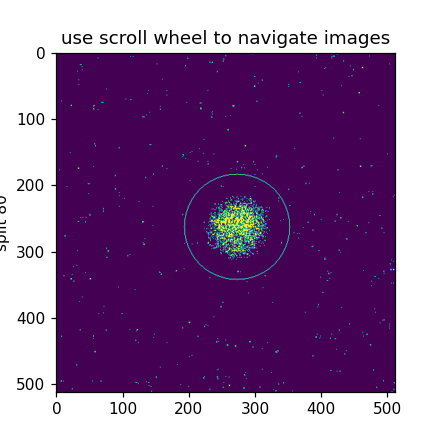

In [15]:
threshold = 12
roi_beg = 150
roi_end = 350

centerx = 273
centery = 262

zar = np.arange(0,zsz)
img_seq = get_image_sequence(video_path)
img_seq_thresh = np.zeros((frame_height, frame_width, len(zar))) # numpy 3d array image sequence to track max intensity images
for zix in range(len(zar)):
#     roi_image = img_seq[150:350, 150:350, zix]
    roi_image = img_seq[:,:,zix].astype(np.uint8)
    # Thresholded image
    ret, threshold_image = cv2.threshold(roi_image, threshold, 255, cv2.THRESH_BINARY)
    boxfiltered_image = cv2.boxFilter(threshold_image, -1, (5,5), normalize=True)
   
    # Use blurred_image for nice plots
#     img_seq_thresh[150:350, 150:350, zix] = boxfiltered_image
    cv2.circle(threshold_image, (centerx, centery), 80, (255,255,255), 1)
    img_seq_thresh[:,:,zix] = threshold_image
        
# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots(1, 1, figsize=(4,4))
tracker = tr.IndexTracker(ax, img_seq_thresh)#, args_dict)
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [ ]:
boxfiltered_image

In [ ]:
img = img_seq[:,:,38]
radius = 100
circle_img = np.zeros((frame_height,frame_width), np.uint8)
cv2.circle(circle_img,(int(centerx),int(centery)), radius,1,thickness=-1)
masked_data = cv2.bitwise_and(img, img, mask=circle_img)
flip_masked_data = cv2.bitwise_and(img, img, mask=(1-circle_img))

masked_mean = masked_data.sum()/circle_img.sum()
flip_masked_mean = flip_masked_data.sum()/(1-circle_img).sum()

display(masked_mean)
display(flip_masked_mean)
display(img.mean())


In [ ]:
centery

## Run through each frame and reduce the frames in the video based on the threshold

In [ ]:
# LxL blocks
zsz = 100
block_length = 512
scale = 512/block_length

Rar_pxl = np.arange(1,block_length/2,dtype=np.int64)
central_sum = np.zeros((len(combined_df), zsz, len(Rar_pxl)))
for tix in range(len(combined_df)):
    print("%d/%d" % (tix,len(combined_df)))
    centerx = int(combined_df.iloc[tix]["centerx"])
    centery = int(combined_df.iloc[tix]["centery"])
    tpix = combined_df.iloc[tix].name
    
    t_str = f"Tp{tpix}"
    
    video_path = video_folder + f"{exp_name}_{t_str}.avi"
    img_seq = get_image_sequence(video_path)
    
    for zix in range(zsz):
        print("\rCalculating %d/%d..." % (zix, zsz), end="")
        sys.stdout.flush()
        img = img_seq[:,:,zix]
        block_img = img_seq[(centery-len(Rar_pxl)):(centery+len(Rar_pxl)),(centerx-len(Rar_pxl)):(centerx+len(Rar_pxl)),zix]
        threshold_image = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        
        for Rix in range(len(Rar_pxl)):
            radius = Rar_pxl[Rix]
            circle_img = np.zeros_like(block_img, np.uint8)
            cv2.circle(circle_img,(int(centerx/scale),int(centery/scale)), radius,1,thickness=-1)
            masked_data = cv2.bitwise_and(block_img, block_img, mask=circle_img)

            central_sum[tix, zix, Rix] = masked_data.sum()

In [ ]:
# For each R value
central_avg = np.zeros_like(central_sum)
for rix in range(len(Rar_pxl)):
    Rpxl = Rar_pxl[rix]
    area = np.pi*Rpxl*Rpxl
    
    central_avg[:,:,rix] = central_sum[:,:,rix]/area

In [ ]:
scale = 512/block_length

In [ ]:
block_img = img_seq[(centery-len(Rar_pxl)):(centery+len(Rar_pxl)),(centerx-len(Rar_pxl)):(centerx+len(Rar_pxl)),zix]
threshold_image = cv2.threshold(block_img, threshold, 255, cv2.THRESH_BINARY)
circle_img = np.zeros_like(block_img, np.uint8)
cv2.circle(circle_img,(int(centerx/scale),int(centery/scale)), 60,1,thickness=-1)
masked_data = cv2.bitwise_and(block_img, block_img, mask=circle_img)

fig,ax = plt.subplots()
ax.imshow(masked_data)



In [ ]:
# Calculate the uniform fit (polyfit with degree=0)
uniform_fit = np.zeros_like(Rar_pxl[:-1])
for ix in range(len(Rar_pxl[:-1])):
    edge_ix = Rar_pxl[ix]
    uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:,0], 0)
    
fig,ax = plt.subplots(1,1)
ax.plot(Rar_pxl, central_sum[:,0])

edge_pxl = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
edge_pxl

# fig, ax = plt.subplots(1,1)
# # ax.plot(Rar_pxl, central_average[:,120])
# radz = Rar_pxl[np.argmax(central_sum,axis=0)]
# # ax.plot(zar, radz, 'o')
# ax.plot(central_sum[:,1])

### Reduced images from the frames of the videos

In [ ]:
# Calculate circular average
# LxL blocks
pxl_threshold = 30
cnt_threshold = 3
block_length = 5

reduced_height = int(frame_height/block_length)
reduced_width = int(frame_width/block_length)

zix = 150
print("\rCalculating %d/%d..." % (zix, frame_count), end="")
sys.stdout.flush()
reduced_avg_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
reduced_cnt_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
img_seq = get_image_sequence(video_folder, acq_name, "t06")
for yix in range(len(reduced_avg_img)):
    for xix in range(len(reduced_avg_img[yix])):
        block_img = img_seq[yix*block_length:(yix+1)*block_length,
                            xix*block_length:(xix+1)*block_length,
                            zix]
        reduced_avg_img[yix,xix] = block_img.mean()
        reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
    
fig,ax = plt.subplots(1,1)
ax.imshow(reduced_cnt_img > cnt_threshold)

### Check the central_sum function for the given params

In [ ]:
img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
(reduced_height, reduced_width) = img.shape

Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

for Rix in range(len(Rar_pxl)):
    radius = Rar_pxl[Rix]

    circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
    cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)

    central_sum[Rix] = masked_data.sum()

# Calculate the uniform fit (polyfit with degree=0)
uniform_fit = np.zeros_like(Rar_pxl[:-1])
for ix in range(len(Rar_pxl[:-1])):
    edge_ix = Rar_pxl[ix]
    uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
    
fig,ax = plt.subplots(1,1)
ax.plot(Rar_pxl, central_sum)

edge_pxl = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
edge_pxl

### Central average throughout all scanning direcions (z and t)

In [ ]:
# Calculate circular average
# LxL blocks
zar = np.arange(0,frame_count)
tar = np.arange(0,8)
# tar = np.array([7])
outer_radius_ar = np.zeros((len(tar), len(zar)))
masked_mean = np.zeros_like(outer_radius_ar)
flip_masked_mean = np.zeros_like(outer_radius_ar)
unmasked_mean = np.zeros_like(outer_radius_ar)
for tix in range(len(tar)):
    t_str = "t%02d" % tar[tix]
    print(t_str)
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
    for zix in range(len(zar)):
        zstrix = zar[zix]
        z_str = "z%03d" % (zstrix)

        print("\rCalculating %d/%d for tix=%d/%d" % (zstrix, frame_count, tix, len(tar)), end="")
        sys.stdout.flush()

        reduced_avg_img = np.zeros((reduced_height, reduced_width))
        reduced_cnt_img = np.zeros_like(reduced_avg_img, dtype=np.int)

        for yix in range(len(reduced_avg_img)):
            for xix in range(len(reduced_avg_img[yix])):
                block_img = img_seq[yix*block_length:(yix+1)*block_length,
                                    xix*block_length:(xix+1)*block_length,
                                    zix]
                reduced_avg_img[yix,xix] = block_img.mean()
                reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()

        img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
        (reduced_height, reduced_width) = img.shape

        Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
        central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

        # Calculate central sum: the sum of intensity of each pixel inside a circle
        for Rix in range(len(Rar_pxl)):
            radius = Rar_pxl[Rix]

            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)

            central_sum[Rix] = masked_data.sum()


        # Calculate the uniform fit (polyfit with degree=0)
        uniform_fit = np.zeros_like(Rar_pxl[:-1])
        for ix in range(len(Rar_pxl[:-1])):
            edge_ix = Rar_pxl[ix]
            uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
        try:
            outer_radius_ar[tix, zix] = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
            radius = np.uint8(outer_radius_ar[tix,zix])
            
            full_img = img_seq[:,:,zix]
            full_circle_img = np.zeros((frame_height, frame_width), np.uint8)
            cv2.circle(full_circle_img, (centerx, centery), int(radius*block_length), 1, thickness=-1)
            
            masked_data = cv2.bitwise_and(full_img, full_img, mask=full_circle_img)
            flip_masked_data = cv2.bitwise_and(full_img, full_img, mask=(1-full_circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/full_circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-full_circle_img).sum()
            unmasked_mean[tix,zix] = full_img.mean()
        except IndexError:
            print("Index Error")
            outer_radius_ar[tix, zix] = 0
            radius = 0
            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius ,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)
            flip_masked_data = cv2.bitwise_and(img, img, mask=(1-circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-circle_img).sum()
            unmasked_mean[tix,zix] = img.mean()

In [ ]:
outer_radius_mm = xsz*tile_xcnt/reduced_height*xvoxel*outer_radius_ar/1e3
zar_mm = zar*zvoxel
df_dict = {"zar (mm)": zar_mm}
for tix in range(len(tar)):
    t_str = "t%02d" % (tix)
    df_dict[f"rad_{t_str} (mm)"] = outer_radius_mm[tix,:]
    df_dict[f"mean_{t_str}"] = unmasked_mean[tix,:]
    df_dict[f"col_mean_{t_str}"] = masked_mean[tix,:]
    df_dict[f"bg_mean_{t_str}"] = flip_masked_mean[tix,:]
    
df = pd.DataFrame(data = df_dict)
df.to_csv(csv_path)

df_metadata = pd.DataFrame({"type": "Movie",
                            "pxl_threshold": pxl_threshold,
                            "cnt_threshold": cnt_threshold,
                            "centerx": centerx,
                            "centery": centery,
                            "block_length": block_length},
                           index = [0])
df_metadata.to_csv(base_folder + f"Resources/{acq_name}_Movie_Metadata.csv")

In [ ]:
# df.plot(x="zar (mm)", y="bg_mean_t00")
fig,ax = plt.subplots(1,1)
# ax.plot(zar, outer_radius_mm[0,:])
ax.imshow(circle_img)

In [ ]:
print(outer_radius_ar.shape)
tar = np.arange(0,8)
height = np.zeros_like(tar)
for tix in range(len(tar)):
    height[tix] = (outer_radius_ar[tix,:]>2).sum()
    
t = tar/2 + 12
h = -height*zvoxel
fig,ax = plt.subplots(1,1, dpi=100)
ax.plot(t, h, 'o')
ax.set_xlim(10,30)
# ax.set_ylim(0,4)
ax.set_xlabel(r'Time after plating')
ax.set_ylabel(r'Colony height (um)')

p = np.polyfit(t[2:],h[2:],1)
tt = np.arange(0,30)
hh = p[0]*tt + p[1]
ax.plot(tt,hh, 'k--')
p

In [ ]:
df

In [ ]:
# df.plot(x="zar (mm)", y="bg_mean_t00")

fig,ax = plt.subplots(1,1)
zar = df["zar (mm)"]
ax.plot(zar, df["bg_mean_t00"],
       zar, df["bg_mean_t01"],
       zar, df["bg_mean_t02"],
       zar, df["bg_mean_t03"],
       zar, df["bg_mean_t04"],
       zar, df["bg_mean_t05"],
       zar, df["bg_mean_t06"],
       zar, df["bg_mean_t07"])

In [ ]:
flip_masked_mean.dtype

In [ ]:
df.plot(x="zar (mm)", y="col_mean_t01")